<a href="https://colab.research.google.com/github/hamasakram/Transfer_Learning-Using-ResNet50-/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Dataset**

In [ ]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset


Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset
License(s): other
 94% 227M/242M [00:01<00:00, 173MB/s]
100% 242M/242M [00:01<00:00, 158MB/s]


**Unzipping**

In [ ]:
import zipfile

with zipfile.ZipFile("5-flower-types-classification-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./flower_dataset")


In [ ]:
import os
os.listdir("./flower_dataset")


['flower_images']

**Generating Example Images**

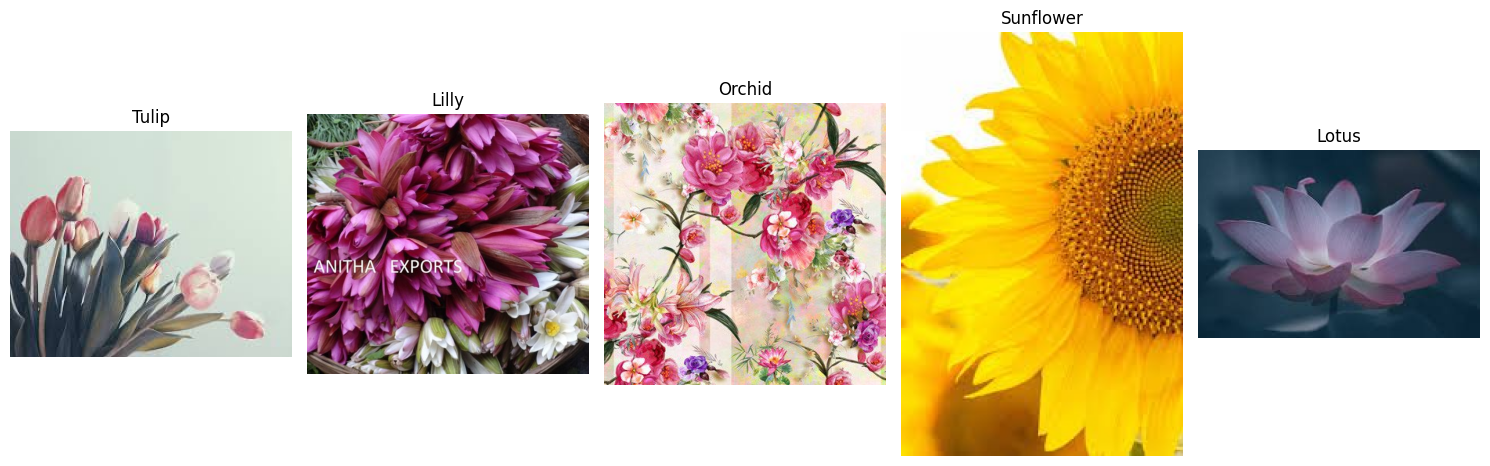

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

dataset_dir = './flower_dataset/flower_images'

categories = os.listdir(dataset_dir)

# Initialize a figure
plt.figure(figsize=(15, 10))

# Loop through the categories and display one image from each
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_dir, category)

    # Get the first image file in the category
    image_file = os.listdir(category_path)[0]
    image_path = os.path.join(category_path, image_file)

    # Open the image using PIL
    image = Image.open(image_path)

    # Plot the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(category, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


**Making Train dataset and Applying Data Augmentation to Reduce Over-Fitting**

In [ ]:
import tensorflow as tf

def augment(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=0.1)

    return image, label

# Load the dataset
data_dir = 'flower_dataset/flower_images'
img_height, img_width = 180, 180
batch_size = 32

# Creating the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Apply the augment function to the training dataset
train_ds = train_ds.map(augment)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 4999 files belonging to 5 classes.
Using 4000 files for training.


**Making Validation Set**

In [ ]:
img_height,img_width=180,180

val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 4999 files belonging to 5 classes.
Using 999 files for validation.


**Checking Classes**

In [ ]:
class_name=train_ds.class_names
print(class_name)

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


**Using RestNet50 & Freezeing the Pre-trained layers**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
resnet_model=Sequential()
from tensorflow.keras.applications import ResNet50
pretrained_model=ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180,180,3),
    pooling='avg',
    classes=5,
    )
for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
#resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(5,activation='softmax'))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Checking Model Summary**

In [ ]:
resnet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Model Compiling**

In [ ]:
#importing optimizer
from tensorflow.keras.optimizers import Adam
#Compiling model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

**Training**

In [ ]:
epochs=10
history=resnet_model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.9764 - loss: 0.0759 - val_accuracy: 0.8398 - val_loss: 0.5917
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.9453 - loss: 0.1522 - val_accuracy: 0.9119 - val_loss: 0.3393
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.9580 - loss: 0.1239 - val_accuracy: 0.9209 - val_loss: 0.2963
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9814 - loss: 0.0565 - val_accuracy: 0.9179 - val_loss: 0.3510
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9802 - loss: 0.0600 - val_accuracy: 0.9329 - val_loss: 0.2798
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9930 - loss: 0.0240 - val_accuracy: 0.9349 - val_loss: 0.2829
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.9924 - loss: 0.0276 - val_accuracy: 0.9369 - val_loss: 0.2667
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.9935 - loss: 0

**Learning_Curve**

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the learning curves for training and validation metrics.

    Parameters:
    - history: Return value from model.fit() containing training history.
    """
    # Extract the history for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'gs-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'gs-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


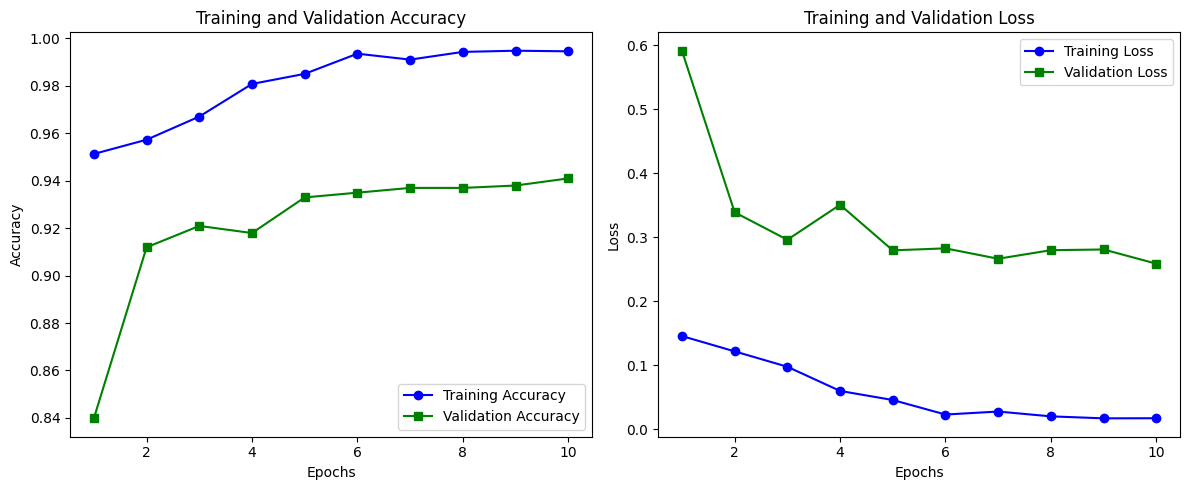

In [ ]:
plot_learning_curve(history)